In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.image_classification.models.efficientnet import efficientnet_b0
from torchvision import transforms
from torchvision.datasets import GTSRB

# Setting

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 32

In [3]:
artifact_path = Path("../../artifacts/efficientnet")
artifact_path.mkdir(exist_ok=True)

data_path = Path("../../data/gtsrb")

In [4]:
device = torch.device("cuda:0")

# data

In [5]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [6]:
train_dataset = GTSRB(
    data_path.as_posix(),
    split="train",
    transform=preprocess,
    download=True,
)

In [7]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [8]:
num_class = 43

In [9]:
len(train_dataset)

26640

10


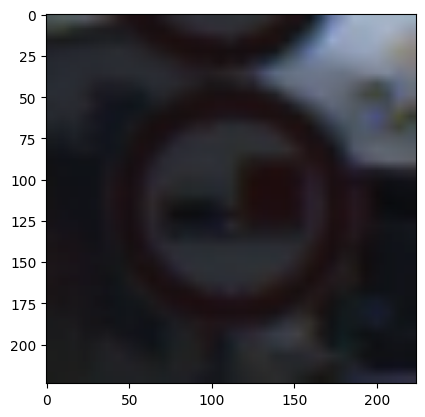

In [10]:
import random
from torchlake.common.utils.convert import img_tensor_to_np

demo_img, demo_label = random.choice(train_dataset)
print(demo_label)
plt.imshow((img_tensor_to_np(demo_img) * IMAGENET_STD + IMAGENET_MEAN).clip(0, 1))

# model

In [11]:
model = efficientnet_b0(output_size=num_class).to(device)

In [12]:
torchinfo.summary(model)

Layer (type:depth-idx)                                            Param #
EfficientNet                                                      --
├─Conv2dNormActivation: 1-1                                       --
│    └─Conv2d: 2-1                                                864
│    └─BatchNorm2d: 2-2                                           64
│    └─ReLU: 2-3                                                  --
├─Sequential: 1-2                                                 --
│    └─InvertedResidualBlock: 2-4                                 --
│    │    └─LinearBottleneck: 3-1                                 1,984
│    └─InvertedResidualBlock: 2-5                                 --
│    │    └─LinearBottleneck: 3-2                                 5,136
│    └─InvertedResidualBlock: 2-6                                 --
│    │    └─ResBlock: 3-3                                         8,832
│    └─InvertedResidualBlock: 2-7                                 --
│    │    └─LinearB

# training

In [13]:
epoches = 10

In [14]:
trainer = ClassificationTrainer(epoches, device)

In [15]:
criterion = trainer.get_criterion(num_class)
optim = torch.optim.Adam(model.parameters())

In [16]:
training_loss = trainer.run(train_loader, model, optim, criterion)

100%|██████████| 832/832 [12:52<00:00,  1.08it/s]


epoch 1 : 0.04305387156805059 (0%)


100%|██████████| 832/832 [02:26<00:00,  5.68it/s]


epoch 2 : 0.007070553591102697 (-84%)


100%|██████████| 832/832 [02:26<00:00,  5.68it/s]


epoch 3 : 0.0038275970698752925 (-46%)


100%|██████████| 832/832 [02:26<00:00,  5.70it/s]


epoch 4 : 0.002962969150517508 (-23%)


100%|██████████| 832/832 [02:26<00:00,  5.69it/s]


epoch 5 : 0.002128508703738528 (-28%)


100%|██████████| 832/832 [02:26<00:00,  5.69it/s]


epoch 6 : 0.002166259008583018 (2%)


100%|██████████| 832/832 [02:27<00:00,  5.63it/s]


epoch 7 : 0.0018788974102156213 (-13%)


100%|██████████| 832/832 [02:27<00:00,  5.65it/s]


epoch 8 : 0.001479805811258053 (-21%)


100%|██████████| 832/832 [02:27<00:00,  5.64it/s]


epoch 9 : 0.001445846910836661 (-2%)


100%|██████████| 832/832 [02:26<00:00,  5.66it/s]

epoch 10 : 0.0012541012707569456 (-13%)


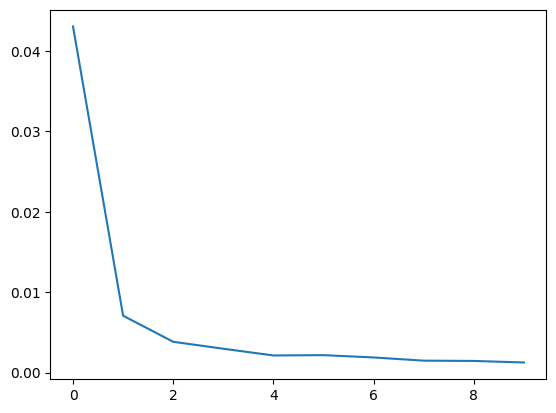

In [17]:
plt.plot(training_loss)

# inference

In [18]:
test_preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [19]:
test_dataset = GTSRB(
    data_path.as_posix(),
    split="test",
    transform=test_preprocess,
    download=True,
)

In [20]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [21]:
evaluator = ClassificationEvaluator(num_class, device)

In [22]:
confusion_matrix = evaluator.run(test_loader, model)

100%|██████████| 395/395 [02:40<00:00,  2.47it/s]

[[ 60   0   0 ...   0   0   0]
 [  0 710   0 ...   0   0   0]
 [  0   0 745 ...   0   0   0]
 ...
 [  0   0   0 ...  77   0   0]
 [  0   0   0 ...   0  54   0]
 [  0   0   0 ...   0   0  64]]


In [23]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(range(num_class), per_class_acc)

0         : 1.0
1         : 0.9861111111111112
2         : 0.9933333333333333
3         : 0.9755555555555555
4         : 0.9954545454545455
5         : 0.9873015873015873
6         : 0.7866666666666666
7         : 0.9977777777777778
8         : 0.96
9         : 0.9770833333333333
10        : 1.0
11        : 0.9952380952380953
12        : 0.9579710144927536
13        : 0.9986111111111111
14        : 0.9962962962962963
15        : 0.9857142857142858
16        : 1.0
17        : 0.9722222222222222
18        : 0.9435897435897436
19        : 0.85
20        : 0.7111111111111111
21        : 0.6555555555555556
22        : 0.75
23        : 1.0
24        : 1.0
25        : 0.9354166666666667
26        : 0.9277777777777778
27        : 0.5
28        : 0.9533333333333334
29        : 0.7444444444444445
30        : 0.9266666666666666
31        : 0.9703703703703703
32        : 0.9333333333333333
33        : 0.9095238095238095
34        : 0.4083333333333333
35        : 0.982051282051282
36        : 0.975

In [24]:
per_class_acc.mean()

0.8885363198760567

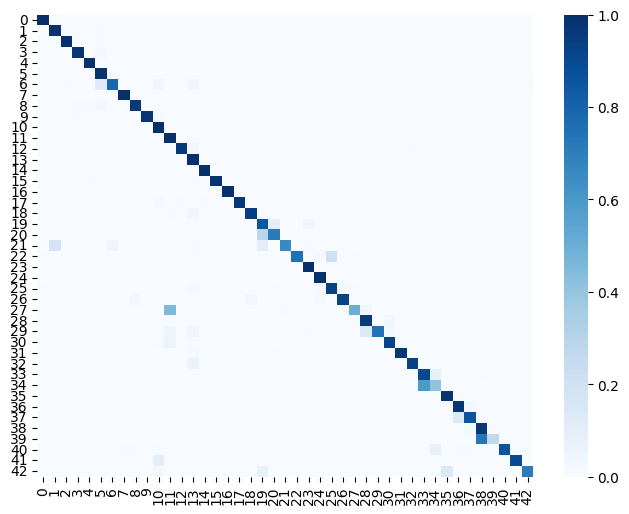

In [25]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    range(num_class),
    "Blues",
    annot=False,
    figsize=(8, 6),
)

In [26]:
model_path = artifact_path / f'efficientnet.b0.pth'

In [27]:
torch.save(model.state_dict(), model_path)

In [28]:
get_file_size(model_path)

'13.35MiB'

In [29]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>